### 출처
https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

In [11]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import regularizers

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 60:
        lrate = 0.005
    if epoch > 120:
        lrate = 0.003
    if epoch > 180:
        lrate = 0.001
    return lrate

In [3]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

x_train, y_train = load_data()

In [4]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train[0][0][0:5]

array([[131., 136., 169.],
       [144., 150., 183.],
       [141., 148., 182.],
       [143., 150., 184.],
       [146., 156., 187.]], dtype=float32)

In [6]:
# z-score : 표준편차를 단위로서 보았을 때 측정치가 평균에서 얼마만큼 일탈하였는가를 보는 것이다. 
#           개인의 측정치 X와 평균치 M과의 차를 표준편차(SD)로 나눈 수이다.
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7) # 각 원소와 평균과의 차이를 표준편차로 나눔(ppt에 나옴 -> normalized data)
x_test = (x_test-mean)/(std+1e-7)
print(mean, std, x_train.shape, x_test.shape)
x_train[0][0][0:5]

120.98071 64.11213 (28000, 32, 32, 3) (12000, 32, 32, 3)


array([[0.15627757, 0.23426592, 0.7489891 ],
       [0.3590473 , 0.45263335, 0.96735656],
       [0.31225428, 0.421438  , 0.95175886],
       [0.34344962, 0.45263335, 0.9829542 ],
       [0.39024264, 0.54621935, 1.0297472 ]], dtype=float32)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [8]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:])) 
# 32x32에 3x3짜리 필터로 padding은 사이즈 유지할 만큼 주고 / l2 regularization을 수행한다(오버피팅 방지), 그리고 input shape을 지정해준다
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

In [9]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [12]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [13]:
# training
batch_size = 128
opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
             optimizer=opt_rms,
             metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=250,
                    verbose=1,validation_data=(x_test,y_test),callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
218/218 [==============================] - 19s 87ms/step - loss: 2.2342 - acc: 0.3512 - val_loss: 1.7044 - val_acc: 0.4796

Epoch 00001: val_loss improved from inf to 1.70440, saving model to ./model/01-1.7044.h5
Epoch 2/250
218/218 [==============================] - 16s 72ms/step - loss: 1.6119 - acc: 0.4854 - val_loss: 1.4233 - val_acc: 0.5458

Epoch 00002: val_loss improved from 1.70440 to 1.42333, saving model to ./model/02-1.4233.h5
Epoch 3/250
218/218 [==============================] - 15s 70ms/step - loss: 1.3486 - acc: 0.5677 - val_loss: 1.5900 - val_acc: 0.5422

Epoch 00003: val_loss did not improve from 1.42333
Epoch 4/250
218/218 [==============================] - 15s 70ms/step - loss: 1.2082 - acc: 0.6159 - val_loss: 1.0096 - val_acc: 0.6767

Epoch 00004: val_loss improved from 1.42333 to 1.00965, saving model to ./model/04-1.0096.h5
Epoch 5/250
218/218 [==============================] - 15s 69ms/step - loss: 1.127

218/218 [==============================] - 15s 68ms/step - loss: 0.6254 - acc: 0.8283 - val_loss: 0.8100 - val_acc: 0.8140

Epoch 00041: val_loss did not improve from 0.67009
Epoch 42/250
218/218 [==============================] - 15s 70ms/step - loss: 0.6200 - acc: 0.8311 - val_loss: 0.7353 - val_acc: 0.8143

Epoch 00042: val_loss did not improve from 0.67009
Epoch 43/250
218/218 [==============================] - 15s 70ms/step - loss: 0.6339 - acc: 0.8275 - val_loss: 0.6259 - val_acc: 0.8343

Epoch 00043: val_loss improved from 0.67009 to 0.62588, saving model to ./model/43-0.6259.h5
Epoch 44/250
218/218 [==============================] - 15s 70ms/step - loss: 0.6169 - acc: 0.8332 - val_loss: 0.6509 - val_acc: 0.8337

Epoch 00044: val_loss did not improve from 0.62588
Epoch 45/250
218/218 [==============================] - 15s 71ms/step - loss: 0.6112 - acc: 0.8346 - val_loss: 0.6476 - val_acc: 0.8335

Epoch 00045: val_loss did not improve from 0.62588
Epoch 46/250
218/218 [=========

218/218 [==============================] - 15s 70ms/step - loss: 0.9209 - acc: 0.7779 - val_loss: 1.0491 - val_acc: 0.7541

Epoch 00084: val_loss did not improve from 0.61781
Epoch 85/250
218/218 [==============================] - 15s 70ms/step - loss: 0.9277 - acc: 0.7781 - val_loss: 1.0454 - val_acc: 0.7619

Epoch 00085: val_loss did not improve from 0.61781
Epoch 86/250
218/218 [==============================] - 15s 70ms/step - loss: 0.9150 - acc: 0.7821 - val_loss: 0.9505 - val_acc: 0.7727

Epoch 00086: val_loss did not improve from 0.61781
Epoch 87/250
218/218 [==============================] - 15s 67ms/step - loss: 0.9166 - acc: 0.7820 - val_loss: 0.9038 - val_acc: 0.7915

Epoch 00087: val_loss did not improve from 0.61781
Epoch 88/250
218/218 [==============================] - 15s 70ms/step - loss: 0.9146 - acc: 0.7842 - val_loss: 0.9829 - val_acc: 0.7737

Epoch 00088: val_loss did not improve from 0.61781
Epoch 89/250
218/218 [==============================] - 15s 70ms/step - l


Epoch 00127: val_loss did not improve from 0.61781
Epoch 128/250
218/218 [==============================] - 15s 68ms/step - loss: 0.7314 - acc: 0.8249 - val_loss: 0.7552 - val_acc: 0.8207

Epoch 00128: val_loss did not improve from 0.61781
Epoch 129/250
218/218 [==============================] - 15s 69ms/step - loss: 0.7160 - acc: 0.8273 - val_loss: 0.8284 - val_acc: 0.7973

Epoch 00129: val_loss did not improve from 0.61781
Epoch 130/250
218/218 [==============================] - 15s 67ms/step - loss: 0.7108 - acc: 0.8296 - val_loss: 0.8693 - val_acc: 0.7927

Epoch 00130: val_loss did not improve from 0.61781
Epoch 131/250
218/218 [==============================] - 15s 70ms/step - loss: 0.7148 - acc: 0.8254 - val_loss: 0.8124 - val_acc: 0.8063

Epoch 00131: val_loss did not improve from 0.61781
Epoch 132/250
218/218 [==============================] - 15s 70ms/step - loss: 0.7122 - acc: 0.8266 - val_loss: 0.7249 - val_acc: 0.8287

Epoch 00132: val_loss did not improve from 0.61781
Epo

218/218 [==============================] - 15s 68ms/step - loss: 0.6902 - acc: 0.8334 - val_loss: 0.7312 - val_acc: 0.8300

Epoch 00171: val_loss did not improve from 0.61781
Epoch 172/250
218/218 [==============================] - 15s 70ms/step - loss: 0.6913 - acc: 0.8347 - val_loss: 0.7416 - val_acc: 0.8270

Epoch 00172: val_loss did not improve from 0.61781
Epoch 173/250
218/218 [==============================] - 15s 68ms/step - loss: 0.6898 - acc: 0.8335 - val_loss: 0.7636 - val_acc: 0.8156

Epoch 00173: val_loss did not improve from 0.61781
Epoch 174/250
218/218 [==============================] - 15s 68ms/step - loss: 0.6916 - acc: 0.8315 - val_loss: 0.7407 - val_acc: 0.8263

Epoch 00174: val_loss did not improve from 0.61781
Epoch 175/250
218/218 [==============================] - 15s 69ms/step - loss: 0.6887 - acc: 0.8333 - val_loss: 0.7166 - val_acc: 0.8308

Epoch 00175: val_loss did not improve from 0.61781
Epoch 176/250
218/218 [==============================] - 15s 68ms/ste

218/218 [==============================] - 15s 70ms/step - loss: 0.4746 - acc: 0.8820 - val_loss: 0.6248 - val_acc: 0.8505

Epoch 00213: val_loss did not improve from 0.50997
Epoch 214/250
218/218 [==============================] - 16s 73ms/step - loss: 0.4698 - acc: 0.8813 - val_loss: 0.5725 - val_acc: 0.8640

Epoch 00214: val_loss did not improve from 0.50997
Epoch 215/250
218/218 [==============================] - 15s 70ms/step - loss: 0.4658 - acc: 0.8833 - val_loss: 0.5910 - val_acc: 0.8543

Epoch 00215: val_loss did not improve from 0.50997
Epoch 216/250
218/218 [==============================] - 15s 70ms/step - loss: 0.4671 - acc: 0.8833 - val_loss: 0.5863 - val_acc: 0.8557

Epoch 00216: val_loss did not improve from 0.50997
Epoch 217/250
218/218 [==============================] - 15s 70ms/step - loss: 0.4691 - acc: 0.8828 - val_loss: 0.5640 - val_acc: 0.8611

Epoch 00217: val_loss did not improve from 0.50997
Epoch 218/250
218/218 [==============================] - 15s 69ms/ste

In [ ]:
# # save to disk
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = '60165060_trained_model.h5'

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

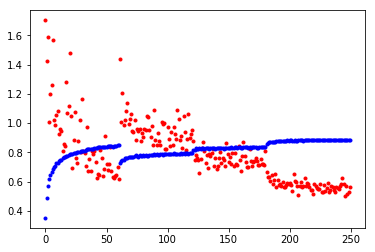

In [14]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_loss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_loss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()
# loss: 1.5541 - acc: 0.4574
# 그냥 baseline 그대로 돌리면 loss 1.4783 acc 0.5014
# loss: 0.4548 - acc: 0.8858 - val_loss: 0.4985 - val_acc: 0.8768 확실히 성능 개선됨

# lr 달리 줬더니 그림이 저렇게 나옴.....

In [15]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

12000/12000 [==============================] - 2s 128us/step

Test result: 86.317 loss: 0.565
